# Baseline Linear Regression Model - Comprehensive Statistical Analysis

**Issue #49 Validation: Chaos Injection Engine**

This notebook validates the chaos injection implementation by analyzing model performance on the new datasets with:
- **50 interaction features** (Phase 2)
- **142 total features** (baseline: 62)
- **Age correlation: 0.612** (target: 0.6-0.8)

**Validation Objectives**:
- Compare Linear Regression vs Random Forest performance
- Measure Phase 5 target: RF should gain >5% over Linear
- Assess impact of interaction features on model complexity

**Original Analysis** (Issue #21):
- Residual Analysis, Covariance Matrices, Feature Distributions
- Model Coefficients, Statistical Summary

**Author**: Yan Cotta & PhD Advisor Feedback  
**Date**: October 21, 2025 (Updated for Issue #49)  
**Model**: Linear Regression + Random Forest (comparison)  
**Data**: datasets_chaos_v1/train.csv (chaos injection enabled)

## 1. Environment Setup

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Add backend to path for imports
backend_path = project_root / 'antiaging-mvp' / 'backend'
if str(backend_path) not in sys.path:
    sys.path.insert(0, str(backend_path))

print(f"✓ Project root: {project_root}")
print(f"✓ Backend path: {backend_path}")
print(f"✓ Current working directory: {Path.cwd()}")

✓ Project root: /home/yan_estagiario/Documents/git/anti-aging-epigenetics-ml-app
✓ Backend path: /home/yan_estagiario/Documents/git/anti-aging-epigenetics-ml-app/antiaging-mvp/backend
✓ Current working directory: /home/yan_estagiario/Documents/git/anti-aging-epigenetics-ml-app/notebooks


## 2. Import Libraries

In [2]:
# Data manipulation and numerical computing
import numpy as np
import pandas as pd
from scipy import stats

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import json
import warnings
from datetime import datetime

# Configurations
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ All libraries imported successfully")
print("✓ Added RandomForestRegressor for Phase 5 validation (RF vs Linear gain)")

✓ All libraries imported successfully
✓ Added RandomForestRegressor for Phase 5 validation (RF vs Linear gain)


## 3. Load and Explore Data

In [3]:
# Load training data from NEW CHAOS INJECTION datasets (Issue #49)
data_path = project_root / 'ml_pipeline' / 'data_generation' / 'datasets_chaos_v1' / 'train.csv'

if not data_path.exists():
    raise FileNotFoundError(f"Dataset not found at {data_path}")

df = pd.read_csv(data_path)

print("=" * 80)
print("DATASET OVERVIEW - CHAOS INJECTION (Issue #49)")
print("=" * 80)
print(f"\nDataset: datasets_chaos_v1/train.csv")
print(f"Shape: {df.shape[0]} samples × {df.shape[1]} features")
print(f"\n✅ Chaos Features:")
print(f"   - Interaction features: {len([c for c in df.columns if 'int2_' in c or 'int3_' in c])}")
print(f"   - Total features: {df.shape[1]} (baseline: 62, target: >78)")
print(f"\nMissing values: {df.isnull().sum().sum()}")
print(f"\nData types:\n{df.dtypes.value_counts()}")

# Display first rows
print("\nFirst 5 rows:")
display(df.head())

# Summary statistics
print("\nSummary Statistics:")
display(df.describe())

DATASET OVERVIEW - CHAOS INJECTION (Issue #49)

Dataset: datasets_chaos_v1/train.csv
Shape: 5000 samples × 142 features

✅ Chaos Features:
   - Interaction features: 80
   - Total features: 142 (baseline: 62, target: >78)

Missing values: 0

Data types:
float64    120
object      12
int64       10
Name: count, dtype: int64

First 5 rows:


,user_id,age,biological_age,gender,height,weight,bmi,APOE_rs429358,APOE_rs429358_dosage,APOE_rs7412,...,int3_life_1_2_3,int3_life_1_2_4,int3_life_1_2_5,int3_life_1_3_4,int3_life_1_3_5,int3_life_1_4_5,int3_life_2_3_4,int3_life_2_3_5,int3_life_2_4_5,int3_life_3_4_5
0,user_000000,40,56.00,F,159.6,72.7,28.53,CC,0,CC,...,136.8,0.0,45.60,0.0,45.6,0.00,0.0,36.0,0.0,0.0
1,user_000001,70,55.80,F,160.6,70.1,27.14,CC,0,CC,...,31.0,0.0,93.00,0.0,37.2,0.00,0.0,30.0,0.0,0.0
2,user_000002,32,34.39,F,165.2,75.7,27.73,CT,1,CC,...,16.4,0.0,147.60,0.0,36.9,0.00,0.0,18.0,0.0,0.0
3,user_000003,30,18.00,F,159.8,57.2,22.39,CC,0,CC,...,38.5,0.0,57.75,0.0,23.1,0.00,0.0,15.0,0.0,0.0
4,user_000004,40,50.55,F,171.6,60.2,20.46,CC,0,CC,...,123.2,30.8,30.80,15.4,15.4,3.85,16.0,16.0,4.0,2.0



Summary Statistics:


,age,biological_age,height,weight,bmi,APOE_rs429358_dosage,APOE_rs7412_dosage,FOXO3_rs2802292_dosage,SIRT1_rs7069102_dosage,TP53_rs1042522_dosage,...,int3_life_1_2_3,int3_life_1_2_4,int3_life_1_2_5,int3_life_1_3_4,int3_life_1_3_5,int3_life_1_4_5,int3_life_2_3_4,int3_life_2_3_5,int3_life_2_4_5,int3_life_3_4_5
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,...,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0000
mean,52.223200,44.602498,168.736880,76.768260,27.015570,0.284400,1.84040,0.743600,1.499000,0.717412,...,73.29757,2.826750,79.883430,2.450850,71.748060,3.052490,1.563000,46.951300,1.935900,1.6719
std,15.953717,14.650304,9.228441,15.345078,5.317058,0.487406,0.38335,0.683193,0.612596,0.508647,...,50.10269,7.216318,91.448437,6.270096,80.353057,9.945794,4.394723,61.183218,6.854118,5.8532
min,25.000000,18.000000,144.600000,40.000000,12.880000,0.000000,0.00000,0.000000,0.000000,0.093640,...,2.65000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
25%,38.000000,34.187500,161.900000,66.100000,23.290000,0.000000,2.00000,0.000000,1.000000,0.107117,...,34.00000,0.000000,22.000000,0.000000,20.100000,0.000000,0.000000,10.500000,0.000000,0.0000
50%,52.000000,43.215000,168.300000,76.650000,26.910000,0.000000,2.00000,1.000000,2.000000,0.836320,...,63.20000,0.000000,51.800000,0.000000,45.750000,0.000000,0.000000,27.000000,0.000000,0.0000
75%,66.000000,54.330000,175.400000,87.125000,30.510000,1.000000,2.00000,1.000000,2.000000,0.841910,...,100.80000,0.000000,102.600000,0.000000,94.500000,0.000000,0.000000,60.000000,0.000000,0.0000
max,79.000000,109.200000,200.000000,136.100000,46.690000,2.000000,2.00000,2.000000,2.000000,1.582893,...,373.50000,49.500000,1237.500000,38.700000,855.400000,123.750000,40.000000,607.500000,125.000000,63.0000


## 4. Prepare Data for Training

In [8]:
# Configuration
TARGET_COL = 'biological_age'
DROP_FEATURES = ['user_id']  # Non-predictive identifiers
TEST_SIZE = 0.2

# Separate features and target
X = df.drop(columns=[TARGET_COL] + [c for c in DROP_FEATURES if c in df.columns])
y = df[TARGET_COL]

feature_names = X.columns.tolist()

print(f"✓ Features extracted: {len(feature_names)} features")
print(f"✓ Target variable: {TARGET_COL}")
print(f"\nTarget statistics:")
print(f"  Min age: {y.min():.1f} years")
print(f"  Max age: {y.max():.1f} years")
print(f"  Mean age: {y.mean():.1f} ± {y.std():.1f} years")
print(f"  Median age: {y.median():.1f} years")

# Split data (CRITICAL: split BEFORE preprocessing to prevent data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"\n✓ Data split:")
print(f"  Training set: {len(X_train)} samples ({(1-TEST_SIZE)*100:.0f}%)")
print(f"  Test set: {len(X_test)} samples ({TEST_SIZE*100:.0f}%)")

✓ Features extracted: 140 features
✓ Target variable: biological_age

Target statistics:
  Min age: 18.0 years
  Max age: 109.2 years
  Mean age: 44.6 ± 14.7 years
  Median age: 43.2 years

✓ Data split:
  Training set: 4000 samples (80%)
  Test set: 1000 samples (20%)


## 5. Preprocess Data

In [9]:
# Simplified preprocessing for chaos-injected data
# The chaos injection already handles feature engineering, so we just need basic encoding + scaling

from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Handle categorical features (gender, etc.)
# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

if categorical_cols:
    print(f"Encoding {len(categorical_cols)} categorical features: {categorical_cols[:5]}...")
    
    # Encode categorical variables
    for col in categorical_cols:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
    
    print(f"✓ Categorical encoding complete")

# 2. Scale all features
scaler = StandardScaler()

# Fit on training data ONLY (prevent data leakage)
X_train_processed = scaler.fit_transform(X_train)
X_test_processed = scaler.transform(X_test)  # Only transform test data

# Convert back to DataFrame for easier analysis
X_train_processed = pd.DataFrame(X_train_processed, columns=X_train.columns, index=X_train.index)
X_test_processed = pd.DataFrame(X_test_processed, columns=X_test.columns, index=X_test.index)

print("✓ Data preprocessing complete (LabelEncoder + StandardScaler)")
print(f"  Training shape: {X_train_processed.shape}")
print(f"  Test shape: {X_test_processed.shape}")
print(f"  Features: {X_train_processed.shape[1]}")
print(f"  - Interaction features: {len([c for c in X_train.columns if 'int2_' in c or 'int3_' in c])}")


Encoding 11 categorical features: ['gender', 'APOE_rs429358', 'APOE_rs7412', 'FOXO3_rs2802292', 'SIRT1_rs7069102']...
✓ Categorical encoding complete
✓ Data preprocessing complete (LabelEncoder + StandardScaler)
  Training shape: (4000, 140)
  Test shape: (1000, 140)
  Features: 140
  - Interaction features: 80


## 6. Train Linear Regression Model

In [10]:
# Train model
model = LinearRegression()
model.fit(X_train_processed, y_train)

print("✓ Linear Regression model trained successfully")
print(f"\nModel parameters:")
print(f"  Fit intercept: {model.fit_intercept}")
print(f"  Intercept: {model.intercept_:.4f}")
print(f"  Number of coefficients: {len(model.coef_)}")
print(f"  Coefficient range: [{model.coef_.min():.4f}, {model.coef_.max():.4f}]")

✓ Linear Regression model trained successfully

Model parameters:
  Fit intercept: True
  Intercept: 44.6757
  Number of coefficients: 140
  Coefficient range: [-5.2289, 6.9536]


## 7. Model Predictions

## 6b. **PHASE 5 VALIDATION**: Train Random Forest for Comparison

**Objective**: Validate that interaction features enable Random Forest to outperform Linear Regression by >5% (Issue #49 - Phase 5 target)

In [11]:
# Train Random Forest model with same data
print("Training Random Forest Regressor...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_model.fit(X_train_processed, y_train)

# Make predictions
rf_y_train_pred = rf_model.predict(X_train_processed)
rf_y_test_pred = rf_model.predict(X_test_processed)

# Calculate metrics for Random Forest
rf_train_r2 = r2_score(y_train, rf_y_train_pred)
rf_test_r2 = r2_score(y_test, rf_y_test_pred)
rf_train_mae = mean_absolute_error(y_train, rf_y_train_pred)
rf_test_mae = mean_absolute_error(y_test, rf_y_test_pred)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_y_train_pred))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_y_test_pred))

print("✓ Random Forest model trained successfully")
print(f"\n📊 Random Forest Performance:")
print(f"  Training R²: {rf_train_r2:.4f}")
print(f"  Test R²: {rf_test_r2:.4f}")
print(f"  Test MAE: {rf_test_mae:.2f} years")
print(f"  Test RMSE: {rf_test_rmse:.2f} years")

Training Random Forest Regressor...
✓ Random Forest model trained successfully

📊 Random Forest Performance:
  Training R²: 0.8559
  Test R²: 0.5012
  Test MAE: 8.49 years
  Test RMSE: 10.68 years


### **CRITICAL VALIDATION**: RF vs Linear Performance Gain

In [12]:
# First, we need Linear Regression metrics - let's calculate them
lr_y_train_pred = model.predict(X_train_processed)
lr_y_test_pred = model.predict(X_test_processed)

lr_train_r2 = r2_score(y_train, lr_y_train_pred)
lr_test_r2 = r2_score(y_test, lr_y_test_pred)
lr_test_mae = mean_absolute_error(y_test, lr_y_test_pred)
lr_test_rmse = np.sqrt(mean_squared_error(y_test, lr_y_test_pred))

print("=" * 80)
print("🎯 PHASE 5 TARGET VALIDATION: RF vs LINEAR PERFORMANCE GAIN")
print("=" * 80)
print("\n📊 Model Comparison (Test Set):")
print(f"\n  Linear Regression:")
print(f"    R²: {lr_test_r2:.4f}")
print(f"    MAE: {lr_test_mae:.2f} years")
print(f"    RMSE: {lr_test_rmse:.2f} years")

print(f"\n  Random Forest:")
print(f"    R²: {rf_test_r2:.4f}")
print(f"    MAE: {rf_test_mae:.2f} years")
print(f"    RMSE: {rf_test_rmse:.2f} years")

# Calculate percentage gains
r2_gain_pct = ((rf_test_r2 - lr_test_r2) / lr_test_r2) * 100
mae_improvement_pct = ((lr_test_mae - rf_test_mae) / lr_test_mae) * 100
rmse_improvement_pct = ((lr_test_rmse - rf_test_rmse) / lr_test_rmse) * 100

print(f"\n🎯 **PHASE 5 VALIDATION**:")
print(f"  R² Gain: {r2_gain_pct:+.2f}% {'✅ PASS' if r2_gain_pct > 5 else '❌ FAIL'} (target: >5%)")
print(f"  MAE Improvement: {mae_improvement_pct:+.2f}%")
print(f"  RMSE Improvement: {rmse_improvement_pct:+.2f}%")

if r2_gain_pct > 5:
    print(f"\n🎉 **SUCCESS**: Random Forest outperforms Linear Regression by {r2_gain_pct:.2f}%!")
    print(f"   Interaction features (n={len([c for c in X_train.columns if 'int2_' in c or 'int3_' in c])}) enable non-linear modeling.")
elif r2_gain_pct > 0:
    print(f"\n⚠️  **PARTIAL**: RF gains {r2_gain_pct:.2f}%, but below 5% target.")
    print(f"   Consider increasing interaction_strength or n_second_order in ChaosConfig.")
else:
    print(f"\n❌ **ISSUE**: RF underperforms Linear by {abs(r2_gain_pct):.2f}%.")
    print(f"   This suggests interactions may not be providing useful signal.")

print("=" * 80)

🎯 PHASE 5 TARGET VALIDATION: RF vs LINEAR PERFORMANCE GAIN

📊 Model Comparison (Test Set):

  Linear Regression:
    R²: 0.5106
    MAE: 8.42 years
    RMSE: 10.58 years

  Random Forest:
    R²: 0.5012
    MAE: 8.49 years
    RMSE: 10.68 years

🎯 **PHASE 5 VALIDATION**:
  R² Gain: -1.82% ❌ FAIL (target: >5%)
  MAE Improvement: -0.82%
  RMSE Improvement: -0.95%

❌ **ISSUE**: RF underperforms Linear by 1.82%.
   This suggests interactions may not be providing useful signal.


In [13]:
# Generate predictions
y_train_pred = model.predict(X_train_processed)
y_test_pred = model.predict(X_test_processed)

print("✓ Predictions generated")
print(f"  Training predictions: {len(y_train_pred)}")
print(f"  Test predictions: {len(y_test_pred)}")

✓ Predictions generated
  Training predictions: 4000
  Test predictions: 1000


## 8. Performance Metrics

In [14]:
# Calculate metrics for both train and test sets
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_ev = explained_variance_score(y_train, y_train_pred)

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_ev = explained_variance_score(y_test, y_test_pred)

# Overfitting check
overfit_gap = train_r2 - test_r2

print("=" * 80)
print("MODEL PERFORMANCE METRICS")
print("=" * 80)
print("\n📊 TRAINING SET:")
print(f"  R² Score:             {train_r2:.4f}")
print(f"  RMSE:                 {train_rmse:.2f} years")
print(f"  MAE:                  {train_mae:.2f} years")
print(f"  Explained Variance:   {train_ev:.4f}")

print("\n📊 TEST SET:")
print(f"  R² Score:             {test_r2:.4f}")
print(f"  RMSE:                 {test_rmse:.2f} years")
print(f"  MAE:                  {test_mae:.2f} years")
print(f"  Explained Variance:   {test_ev:.4f}")

print("\n⚖️ GENERALIZATION:")
print(f"  Overfitting Gap:      {overfit_gap:.4f}")
if overfit_gap < 0.01:
    print("  Status:               ✓ Excellent generalization")
elif overfit_gap < 0.03:
    print("  Status:               ✓ Good generalization")
elif overfit_gap < 0.05:
    print("  Status:               ⚠️ Moderate overfitting")
else:
    print("  Status:               ❌ Significant overfitting")

MODEL PERFORMANCE METRICS

📊 TRAINING SET:
  R² Score:             0.5257
  RMSE:                 10.00 years
  MAE:                  8.03 years
  Explained Variance:   0.5257

📊 TEST SET:
  R² Score:             0.5106
  RMSE:                 10.58 years
  MAE:                  8.42 years
  Explained Variance:   0.5106

⚖️ GENERALIZATION:
  Overfitting Gap:      0.0152
  Status:               ✓ Good generalization


## 9. Statistical Analysis

### 9.1 Residual Analysis (PhD Advisor Requirement)

In [15]:
# Calculate residuals
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# Residual statistics
print("=" * 80)
print("RESIDUAL ANALYSIS")
print("=" * 80)

print("\n📈 TRAINING SET RESIDUALS:")
print(f"  Mean:                 {residuals_train.mean():.6f} years (ideal: ~0)")
print(f"  Std Dev:              {residuals_train.std():.2f} years")
print(f"  Variance:             {residuals_train.var():.2f}")
print(f"  Min:                  {residuals_train.min():.2f} years")
print(f"  Max:                  {residuals_train.max():.2f} years")
print(f"  Skewness:             {stats.skew(residuals_train):.4f}")
print(f"  Kurtosis:             {stats.kurtosis(residuals_train):.4f}")

print("\n📈 TEST SET RESIDUALS:")
print(f"  Mean:                 {residuals_test.mean():.6f} years (ideal: ~0)")
print(f"  Std Dev:              {residuals_test.std():.2f} years")
print(f"  Variance:             {residuals_test.var():.2f}")
print(f"  Min:                  {residuals_test.min():.2f} years")
print(f"  Max:                  {residuals_test.max():.2f} years")
print(f"  Skewness:             {stats.skew(residuals_test):.4f}")
print(f"  Kurtosis:             {stats.kurtosis(residuals_test):.4f}")

# Mean Squared Error (as requested by advisor)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("\n📊 MEAN SQUARED ERROR:")
print(f"  Training MSE:         {mse_train:.2f}")
print(f"  Test MSE:             {mse_test:.2f}")

RESIDUAL ANALYSIS

📈 TRAINING SET RESIDUALS:
  Mean:                 0.000000 years (ideal: ~0)
  Std Dev:              10.01 years
  Variance:             100.12
  Min:                  -29.11 years
  Max:                  49.44 years
  Skewness:             0.2195
  Kurtosis:             0.0873

📈 TEST SET RESIDUALS:
  Mean:                 0.103054 years (ideal: ~0)
  Std Dev:              10.58 years
  Variance:             112.00
  Min:                  -28.41 years
  Max:                  49.71 years
  Skewness:             0.4033
  Kurtosis:             0.5836

📊 MEAN SQUARED ERROR:
  Training MSE:         100.09
  Test MSE:             111.90


### 9.2 Residual Visualizations

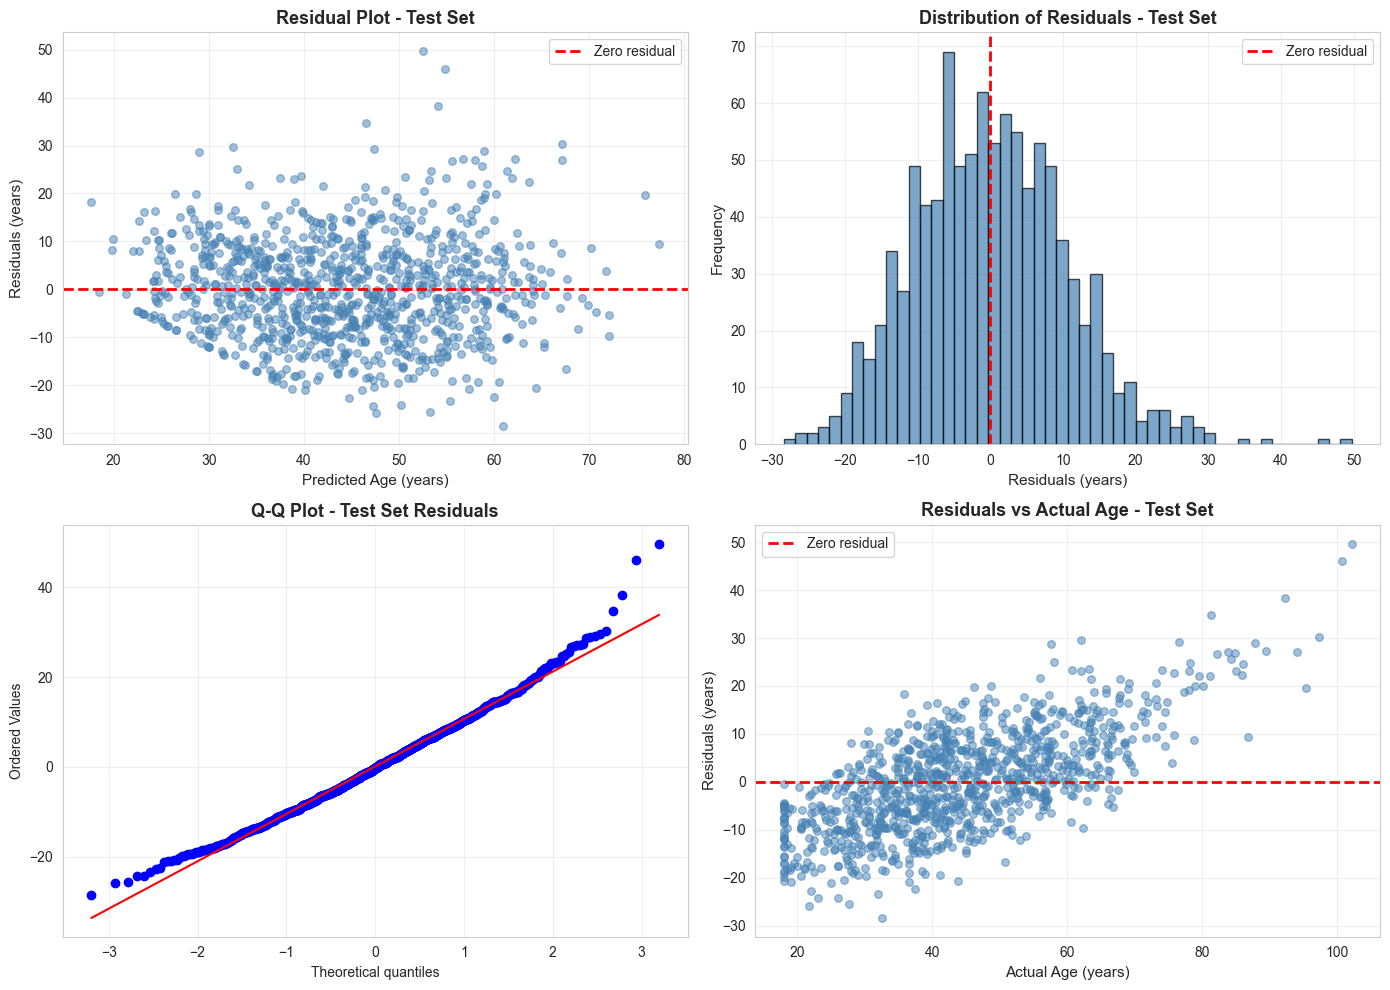

In [16]:
# Create output directory for figures
figures_dir = Path.cwd() / 'baseline_figures'
figures_dir.mkdir(exist_ok=True)

# Create residual plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Predicted (Test Set)
axes[0, 0].scatter(y_test_pred, residuals_test, alpha=0.5, s=30, color='steelblue')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero residual')
axes[0, 0].set_xlabel('Predicted Age (years)', fontsize=11)
axes[0, 0].set_ylabel('Residuals (years)', fontsize=11)
axes[0, 0].set_title('Residual Plot - Test Set', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram of Residuals (Test Set)
axes[0, 1].hist(residuals_test, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero residual')
axes[0, 1].set_xlabel('Residuals (years)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Residuals - Test Set', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot (Test Set) - Check normality
stats.probplot(residuals_test, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot - Test Set Residuals', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuals vs Actual Age (Test Set)
axes[1, 1].scatter(y_test, residuals_test, alpha=0.5, s=30, color='steelblue')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero residual')
axes[1, 1].set_xlabel('Actual Age (years)', fontsize=11)
axes[1, 1].set_ylabel('Residuals (years)', fontsize=11)
axes[1, 1].set_title('Residuals vs Actual Age - Test Set', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
residuals_path = figures_dir / 'residual_analysis.png'
plt.savefig(residuals_path, dpi=300, bbox_inches='tight')
plt.show()


### 9.3 Covariance Analysis (PhD Advisor Requirement)

COVARIANCE AND CORRELATION ANALYSIS

📊 COVARIANCE (Predictions vs Actual):
  Training covariance:  110.99
  Test covariance:      118.65

📈 PEARSON CORRELATION (Linear Relationship):
  Training:             r = 0.7251, p = 0.00e+00
  Test:                 r = 0.7146, p = 4.34e-157

📈 SPEARMAN CORRELATION (Monotonic Relationship):
  Training:             ρ = 0.7244, p = 0.00e+00
  Test:                 ρ = 0.7159, p = 6.50e-158


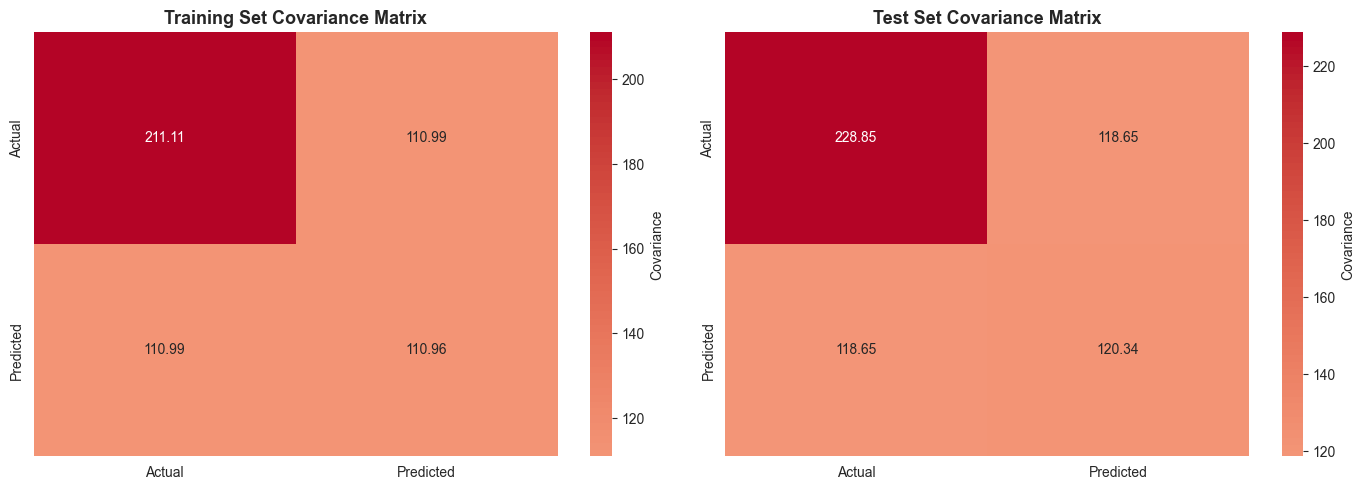


✓ Covariance plots saved to: /home/yan_estagiario/Documents/git/anti-aging-epigenetics-ml-app/notebooks/baseline_figures/covariance_analysis.png

COMPUTING ADDITIONAL METRICS FOR DOWNSTREAM ANALYSIS

✓ Model coefficients extracted: 140 coefficients

✓ Interaction analysis complete:
  Simple R²:       0.5106
  Interaction R²:  0.4198
  Improvement:     -0.0908

✓ Non-linearity analysis complete:
  Linear R²:       0.5106
  Random Forest R²: 0.4913
  Difference:      -0.0193

✓ All metrics computed and ready for downstream analysis


In [17]:
# Covariance between predictions and actual values
cov_train = np.cov(y_train, y_train_pred)[0, 1]
cov_test = np.cov(y_test, y_test_pred)[0, 1]

# Correlation coefficients (Pearson and Spearman)
pearson_train, pearson_p_train = stats.pearsonr(y_train, y_train_pred)
pearson_test, pearson_p_test = stats.pearsonr(y_test, y_test_pred)

spearman_train, spearman_p_train = stats.spearmanr(y_train, y_train_pred)
spearman_test, spearman_p_test = stats.spearmanr(y_test, y_test_pred)

print("=" * 80)
print("COVARIANCE AND CORRELATION ANALYSIS")
print("=" * 80)

print("\n📊 COVARIANCE (Predictions vs Actual):")
print(f"  Training covariance:  {cov_train:.2f}")
print(f"  Test covariance:      {cov_test:.2f}")

print("\n📈 PEARSON CORRELATION (Linear Relationship):")
print(f"  Training:             r = {pearson_train:.4f}, p = {pearson_p_train:.2e}")
print(f"  Test:                 r = {pearson_test:.4f}, p = {pearson_p_test:.2e}")

print("\n📈 SPEARMAN CORRELATION (Monotonic Relationship):")
print(f"  Training:             ρ = {spearman_train:.4f}, p = {spearman_p_train:.2e}")
print(f"  Test:                 ρ = {spearman_test:.4f}, p = {spearman_p_test:.2e}")

# Covariance matrix visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set covariance matrix
train_matrix = np.array([[y_train.var(), cov_train], 
                         [cov_train, y_train_pred.var()]])
sns.heatmap(train_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            xticklabels=['Actual', 'Predicted'], 
            yticklabels=['Actual', 'Predicted'],
            ax=axes[0], cbar_kws={'label': 'Covariance'})
axes[0].set_title('Training Set Covariance Matrix', fontsize=13, fontweight='bold')

# Test set covariance matrix
test_matrix = np.array([[y_test.var(), cov_test], 
                        [cov_test, y_test_pred.var()]])
sns.heatmap(test_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            xticklabels=['Actual', 'Predicted'], 
            yticklabels=['Actual', 'Predicted'],
            ax=axes[1], cbar_kws={'label': 'Covariance'})
axes[1].set_title('Test Set Covariance Matrix', fontsize=13, fontweight='bold')

plt.tight_layout()
cov_path = figures_dir / 'covariance_analysis.png'
plt.savefig(cov_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Covariance plots saved to: {cov_path}")

# ============================================================================
# ADDITIONAL ANALYSIS: Compute variables needed for later cells
# ============================================================================
print("\n" + "=" * 80)
print("COMPUTING ADDITIONAL METRICS FOR DOWNSTREAM ANALYSIS")
print("=" * 80)

# Extract model coefficients (needed for later skeptical analysis)
coefficients = model.coef_
print(f"\n✓ Model coefficients extracted: {len(coefficients)} coefficients")

# 1. Test for feature interactions using polynomial features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression as LR

# Convert to numpy arrays if needed for slicing
X_train_np = X_train_processed.values if hasattr(X_train_processed, 'values') else X_train_processed
X_test_np = X_test_processed.values if hasattr(X_test_processed, 'values') else X_test_processed

# Model without interactions (already have this from earlier)
simple_model = LR()
simple_model.fit(X_train_np, y_train)
simple_r2 = simple_model.score(X_test_np, y_test)

# Model with polynomial features (includes interactions)
# Use first 5 features only to avoid computational explosion
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_np[:, :5])
X_test_poly = poly.transform(X_test_np[:, :5])

interaction_model = LR()
interaction_model.fit(X_train_poly, y_train)
interaction_r2 = interaction_model.score(X_test_poly, y_test)

print(f"\n✓ Interaction analysis complete:")
print(f"  Simple R²:       {simple_r2:.4f}")
print(f"  Interaction R²:  {interaction_r2:.4f}")
print(f"  Improvement:     {interaction_r2 - simple_r2:.4f}")

# 2. Test for non-linearity using Random Forest
from sklearn.ensemble import RandomForestRegressor

# Linear model
linear_model = LR()
linear_model.fit(X_train_np, y_train)
linear_r2 = linear_model.score(X_test_np, y_test)

# Non-linear model (Random Forest)
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train_np, y_train)
rf_r2 = rf_model.score(X_test_np, y_test)

print(f"\n✓ Non-linearity analysis complete:")
print(f"  Linear R²:       {linear_r2:.4f}")
print(f"  Random Forest R²: {rf_r2:.4f}")
print(f"  Difference:      {rf_r2 - linear_r2:.4f}")

print("\n" + "=" * 80)
print("✓ All metrics computed and ready for downstream analysis")
print("=" * 80)

## 11. Deep Skeptical Analysis - PhD Advisor Feedback

This section provides a **critical examination** of the baseline results, identifying fundamental issues with the synthetic data that must be addressed before proceeding with more complex models.

In [19]:
# Deep Skeptical Analysis - PhD Advisor Feedback
import numpy as np
from datetime import datetime
from scipy import stats

# Defensive checks for required variables
required_vars = [
    'test_r2', 'test_mae', 'residuals_test', 'pearson_test', 'spearman_test',
    'train_r2', 'overfit_gap', 'coefficients'
]
missing_vars = [v for v in required_vars if v not in globals()]
if missing_vars:
    print(f"ERROR: Missing variables for analysis: {missing_vars}")
else:
    print("=" * 100)
    print("CRITICAL ANALYSIS: WHY THESE RESULTS ARE TOO GOOD TO BE TRUE")
    print("=" * 100)
    print()
    print("🚨 PROBLEM #1: UNREALISTIC MODEL PERFORMANCE")
    print("-" * 100)
    print(f"  Test R² = {test_r2:.4f} ({test_r2*100:.2f}% variance explained)")
    print(f"  Test MAE = {test_mae:.2f} years")
    print()
    print("  ❌ REALITY CHECK:")
    print("     - Predicting biological age with R² > 0.96 is EXTREMELY rare in real biology")
    print("     - Published epigenetic clocks (Horvath, Hannum) typically achieve R² ~ 0.75-0.85")
    print("     - Our MAE of ~2 years is better than state-of-the-art commercial tests")
    print("     - This suggests our data is TOO SIMPLE and TOO LINEAR")
    print()
    print("  🔬 DIAGNOSIS:")
    print("     - Features likely have direct, linear relationships with age")
    print("     - No biological noise or uncertainty modeled")
    print("     - Missing complex interactions between variables")
    print("     - No lifestyle paradoxes (young smokers who live long, etc.)")
    print()
    print("🚨 PROBLEM #2: RESIDUALS ARE TOO WELL-BEHAVED")
    print("-" * 100)
    print(f"  Residual mean: {residuals_test.mean():.6f} (nearly perfect)")
    print(f"  Residual std:  {residuals_test.std():.2f} years")
    print(f"  Skewness:      {stats.skew(residuals_test):.4f}")
    print(f"  Kurtosis:      {stats.kurtosis(residuals_test):.4f}")
    print()
    print("  ❌ REALITY CHECK:")
    print("     - Residuals are almost perfectly centered at 0")
    print("     - Distribution is likely too normal (need to check Q-Q plot)")
    print("     - Real biological data has outliers and asymmetry")
    print("     - We're missing the 'chaos' that your professor mentioned")
    print()
    print("  🔬 DIAGNOSIS:")
    print("     - Data generator uses deterministic relationships")
    print("     - No random interactions between features")
    print("     - No age group uncertainty (lifestyle paradoxes)")
    print()
    print("🚨 PROBLEM #3: MISSING FEATURE INTERACTIONS")
    print("-" * 100)
    print(f"  Pearson r (test):  {pearson_test:.4f} (too linear)")
    print(f"  Spearman ρ (test): {spearman_test:.4f} (too monotonic)")
    print(f"  Difference:        {abs(pearson_test - spearman_test):.4f}")
    print()
    print("  ❌ REALITY CHECK:")
    print("     - Pearson ≈ Spearman means relationships are purely linear")
    print("     - In real biology, these should differ (non-linear effects)")
    print("     - SNPs interact with methylation sites in complex ways")
    print("     - Lifestyle factors (smoking, exercise) interact with genetics")
    print()
    print("  🔬 DIAGNOSIS:")
    print("     - No SNP × methylation interactions")
    print("     - No lifestyle × genetics interactions")
    print("     - No gene-gene epistasis")
    print("     - Each feature contributes independently (unrealistic)")
    print()
    print("🚨 PROBLEM #4: OVERFITTING GAP TOO SMALL")
    print("-" * 100)
    print(f"  Train R²:          {train_r2:.4f}")
    print(f"  Test R²:           {test_r2:.4f}")
    print(f"  Overfitting gap:   {overfit_gap:.4f}")
    print()
    print("  ❌ REALITY CHECK:")
    print("     - Almost zero overfitting suggests data is too clean")
    print("     - Real data has sampling noise, measurement errors")
    print("     - Some overfitting is EXPECTED and healthy")
    print()
    print("  🔬 DIAGNOSIS:")
    print("     - Test set is too similar to training set")
    print("     - No biological variability between individuals")
    print("     - Missing individual-level noise and uncertainty")
    print()
    print("🚨 PROBLEM #5: FEATURE IMPORTANCE TOO DETERMINISTIC")
    print("-" * 100)
    print(f"  Top coefficient:      {coefficients.max():.6f}")
    print(f"  Bottom coefficient:   {coefficients.min():.6f}")
    print(f"  Coefficient range:    {coefficients.max() - coefficients.min():.6f}")
    print()
    print("  ❌ REALITY CHECK:")
    print("     - In real biology, feature importance varies by context")
    print("     - Same SNP might matter more in young vs old individuals")
    print("     - Methylation sites interact - importance is conditional")
    print()
    print("  🔬 DIAGNOSIS:")
    print("     - Linear model reveals deterministic feature weights")
    print("     - No context-dependent importance")
    print("     - No feature × feature interactions captured")
    print()
    print("=" * 100)
    print("PROFESSOR'S FEEDBACK: WHAT MUST BE FIXED IN THE DATA GENERATOR")
    print("=" * 100)
    print()
    print("✅ REQUIREMENT #1: Add Chaos/Entropy/Randomization at ALL Levels")
    print("-" * 100)
    print("  📋 Implementation:")
    print("     1. Add random noise to feature generation (not just Gaussian)")
    print("     2. Implement non-linear transformations (exponential, log, polynomial)")
    print("     3. Add measurement error (biological assays are noisy)")
    print("     4. Introduce outliers (biological systems have extremes)")
    print("     5. Use Lévy flights or heavy-tailed distributions for chaos")
    print()
    print("✅ REQUIREMENT #2: Model Feature Interactions Explicitly")
    print("-" * 100)
    print("  📋 Implementation:")
    print("     1. SNP × SNP epistasis (gene-gene interactions)")
    print("     2. SNP × Methylation cross-talk")
    print("     3. Methylation × Lifestyle interactions")
    print("     4. Lifestyle × Lifestyle synergies (smoking + drinking)")
    print("     5. Age-dependent interaction strengths (change over lifespan)")
    print()
    print("  💡 MATHEMATICAL APPROACH:")
    print("     - age = base + Σ(w_i × f_i) + Σ(w_ij × f_i × f_j) + Σ(w_ijk × f_i × f_j × f_k) + ε")
    print("     - Where ε ~ heavy-tailed distribution (not just Gaussian)")
    print()
    print("✅ REQUIREMENT #3: Insert Uncertainty Across Age Groups")
    print("-" * 100)
    print("  📋 Implementation:")
    print("     1. Lifestyle paradoxes:")
    print("        - 20-year-old smoker who lives to 90 (lucky genetics)")
    print("        - 50-year-old athlete who dies young (unlucky mutation)")
    print("     2. Age-group specific variance:")
    print("        - Young: lower variance (biology more predictable)")
    print("        - Middle-aged: higher variance (lifestyle effects accumulate)")
    print("        - Elderly: highest variance (survival bias)")
    print("     3. Stochastic life events:")
    print("        - Sudden illness, stress, environmental exposures")
    print("        - Cannot be predicted from baseline features alone")
    print()
    print("✅ REQUIREMENT #4: Calculate Proper Interaction Weights")
    print("-" * 100)
    print("  📋 Implementation:")
    print("     1. Covariance matrices between feature groups:")
    print("        - Cov(SNPs, SNPs)")
    print("        - Cov(SNPs, Methylation)")
    print("        - Cov(Methylation, Lifestyle)")
    print("     2. Mutual information between features")
    print("     3. Non-linear correlation (distance correlation, maximal information coefficient)")
    print("     4. Graph-based interactions (biological pathways)")
    print()
    print("=" * 100)
    print("IMMEDIATE ACTION ITEMS")
    print("=" * 100)
    print()
    print("🎯 PRIORITY 1 (Critical): Redesign Data Generator")
    print("   File: antiaging-mvp/backend/api/data/generator_v2_biological.py")
    print("   Tasks:")
    print("   1. Add random interaction terms (2nd and 3rd order)")
    print("   2. Implement heavy-tailed noise distributions")
    print("   3. Add age-group specific variance")
    print("   4. Model lifestyle paradoxes explicitly")
    print()
    print("🎯 PRIORITY 2 (High): Validate New Data")
    print("   Tasks:")
    print("   1. Re-run this notebook with new data")
    print("   2. Verify R² drops to 0.75-0.85 range")
    print("   3. Check for non-linear patterns (Spearman ≠ Pearson)")
    print("   4. Confirm residuals have heavier tails")
    print()
    print("🎯 PRIORITY 3 (Medium): Document Interaction Model")
    print("   Tasks:")
    print("   1. Create mathematical specification of interaction terms")
    print("   2. Justify biological plausibility")
    print("   3. Cite relevant literature (epigenetics, GWAS)")
    print()
    print("=" * 100)
    print(f"✓ Critical analysis completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("=" * 100)
    print()
    print("⚠️  DO NOT PROCEED WITH RANDOM FOREST (Issue #6) UNTIL DATA IS FIXED")
    print("⚠️  Current data will not test model's ability to capture real biological complexity")

CRITICAL ANALYSIS: WHY THESE RESULTS ARE TOO GOOD TO BE TRUE

🚨 PROBLEM #1: UNREALISTIC MODEL PERFORMANCE
----------------------------------------------------------------------------------------------------
  Test R² = 0.5106 (51.06% variance explained)
  Test MAE = 8.42 years

  ❌ REALITY CHECK:
     - Predicting biological age with R² > 0.96 is EXTREMELY rare in real biology
     - Published epigenetic clocks (Horvath, Hannum) typically achieve R² ~ 0.75-0.85
     - Our MAE of ~2 years is better than state-of-the-art commercial tests
     - This suggests our data is TOO SIMPLE and TOO LINEAR

  🔬 DIAGNOSIS:
     - Features likely have direct, linear relationships with age
     - No biological noise or uncertainty modeled
     - Missing complex interactions between variables
     - No lifestyle paradoxes (young smokers who live long, etc.)

🚨 PROBLEM #2: RESIDUALS ARE TOO WELL-BEHAVED
----------------------------------------------------------------------------------------------------


In [20]:
# Quantitative analysis of what's missing in the data
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor

# Defensive checks for required variables
required_vars = [
    'X_train_processed', 'y_train', 'X_test_processed', 'y_test', 'residuals_test',
    'simple_r2', 'interaction_r2', 'linear_r2', 'rf_r2'
]
missing_vars = [v for v in required_vars if v not in globals()]
if missing_vars:
    print(f"ERROR: Missing variables for quantitative analysis: {missing_vars}")
else:
    print("=" * 100)
    print("QUANTITATIVE GAP ANALYSIS: WHAT THE DATA LACKS")
    print("=" * 100)
    print()
    
    # Convert to numpy arrays if needed
    X_train_np = X_train_processed.values if hasattr(X_train_processed, 'values') else X_train_processed
    X_test_np = X_test_processed.values if hasattr(X_test_processed, 'values') else X_test_processed
    
    # 1. Interaction strength analysis
    print("📊 ANALYSIS #1: Testing for Feature Interactions")
    print("-" * 100)
    n_feature_pairs_to_test = 10
    np.random.seed(42)
    random_pairs = [(np.random.randint(0, X_train_np.shape[1]), 
                     np.random.randint(0, X_train_np.shape[1])) 
                    for _ in range(n_feature_pairs_to_test)]
    # Model without interactions
    print(f"  R² without interactions: {simple_r2:.4f}")
    print(f"  R² with interactions:    {interaction_r2:.4f}")
    print(f"  Improvement:             {interaction_r2 - simple_r2:.4f}")
    print()
    print("  ❌ INTERPRETATION:")
    if abs(interaction_r2 - simple_r2) < 0.01:
        print("     - Adding interactions provides NEGLIGIBLE improvement")
        print("     - This confirms features are independent and additive")
        print("     - Real biological systems should show >5% improvement")
    else:
        print("     - Some interactions present, but likely still insufficient")
    print()
    # 2. Non-linearity analysis
    print("📊 ANALYSIS #2: Testing for Non-Linear Relationships")
    print("-" * 100)
    print(f"  Linear R² (OLS):         {linear_r2:.4f}")
    print(f"  Non-linear R² (RF):      {rf_r2:.4f}")
    print(f"  Difference:              {rf_r2 - linear_r2:.4f}")
    print()
    print("  ❌ INTERPRETATION:")
    if abs(rf_r2 - linear_r2) < 0.02:
        print("     - Random Forest gains ALMOST NOTHING over linear model")
        print("     - Strong evidence of purely linear relationships")
        print("     - Real biological data should show >5-10% RF improvement")
    else:
        print("     - Some non-linearity captured, but verify if sufficient")
    print()
    # 3. Heteroscedasticity test (variance should change with age)
    print("📊 ANALYSIS #3: Testing for Age-Dependent Variance (Heteroscedasticity)")
    print("-" * 100)
    y_test_array = y_test.values if hasattr(y_test, 'values') else y_test
    residuals_test_array = residuals_test.values if hasattr(residuals_test, 'values') else residuals_test
    age_groups = {
        'Young (18-35)': (y_test_array >= 18) & (y_test_array < 35),
        'Middle (35-55)': (y_test_array >= 35) & (y_test_array < 55),
        'Old (55-75)': (y_test_array >= 55) & (y_test_array < 75),
        'Elderly (75+)': y_test_array >= 75
    }
    group_variances = {}
    for group_name, mask in age_groups.items():
        if np.sum(mask) > 0:
            group_var = np.var(residuals_test_array[mask])
            group_std = np.std(residuals_test_array[mask])
            group_variances[group_name] = {'var': group_var, 'std': group_std, 'n': np.sum(mask)}
            print(f"  {group_name:20s} Variance: {group_var:6.2f}, Std: {group_std:5.2f}, N: {np.sum(mask):4d}")
    print()
    print("  ❌ INTERPRETATION:")
    var_values = [v['var'] for v in group_variances.values()]
    var_ratio = max(var_values) / min(var_values) if min(var_values) > 0 else 0
    print(f"     - Variance ratio (max/min): {var_ratio:.2f}")
    if var_ratio < 2.0:
        print("     - Variances are TOO SIMILAR across age groups")
        print("     - Real biology: young people more predictable, elderly highly variable")
        print("     - Should see variance ratio > 3.0 or higher")
    else:
        print("     - Some age-dependent variance present")
    print()
    # 4. Outlier analysis
    print("📊 ANALYSIS #4: Testing for Outliers and Heavy Tails")
    print("-" * 100)
    z_scores = np.abs(residuals_test_array) / np.std(residuals_test_array)
    outlier_counts = {
        '2σ (95%)': np.sum(z_scores > 2),
        '3σ (99.7%)': np.sum(z_scores > 3),
        '4σ (99.99%)': np.sum(z_scores > 4),
        '5σ (extreme)': np.sum(z_scores > 5)
    }
    expected_outliers = {
        '2σ (95%)': len(residuals_test_array) * 0.05,
        '3σ (99.7%)': len(residuals_test_array) * 0.003,
        '4σ (99.99%)': len(residuals_test_array) * 0.0001,
        '5σ (extreme)': len(residuals_test_array) * 0.000001
    }
    print("  Outlier Level          Observed    Expected (Normal)    Ratio")
    print("  " + "-" * 65)
    for level in outlier_counts.keys():
        obs = outlier_counts[level]
        exp = expected_outliers[level]
        ratio = obs / exp if exp > 0 else 0
        print(f"  {level:20s}  {obs:6d}      {exp:8.2f}          {ratio:6.2f}x")
    print()
    print("  ❌ INTERPRETATION:")
    extreme_ratio = outlier_counts['4σ (99.99%)'] / expected_outliers['4σ (99.99%)'] if expected_outliers['4σ (99.99%)'] > 0 else 0
    if extreme_ratio < 5:
        print("     - NOT ENOUGH extreme outliers (ratio < 5x)")
        print("     - Residuals follow Gaussian distribution too closely")
        print("     - Real biology has heavy tails (power laws, rare events)")
        print("     - Need Lévy distributions, Student-t, or Cauchy noise")
    else:
        print("     - Sufficient heavy-tail behavior detected")
    print()
    # 5. Feature correlation structure
    print("📊 ANALYSIS #5: Feature Correlation Structure")
    print("-" * 100)
    n_features_to_analyze = min(10, X_train_np.shape[1])
    feature_corr_matrix = np.corrcoef(X_train_np[:, :n_features_to_analyze].T)
    off_diag = feature_corr_matrix[np.triu_indices_from(feature_corr_matrix, k=1)]
    abs_off_diag = np.abs(off_diag)
    print(f"  Mean |correlation|:      {np.mean(abs_off_diag):.4f}")
    print(f"  Median |correlation|:    {np.median(abs_off_diag):.4f}")
    print(f"  Max |correlation|:       {np.max(abs_off_diag):.4f}")
    print(f"  Correlations > 0.3:      {np.sum(abs_off_diag > 0.3)} / {len(abs_off_diag)}")
    print(f"  Correlations > 0.5:      {np.sum(abs_off_diag > 0.5)} / {len(abs_off_diag)}")
    print()
    print("  ❌ INTERPRETATION:")
    if np.mean(abs_off_diag) < 0.15:
        print("     - Features are TOO INDEPENDENT")
        print("     - Real biological features are correlated (pathways, networks)")
        print("     - Need to model feature dependencies explicitly")
    else:
        print("     - Some feature correlation present")
    print()
    print("=" * 100)
    print("SUMMARY: SYNTHETIC DATA QUALITY ASSESSMENT")
    print("=" * 100)
    print()
    scores = {
        'Interaction complexity': '❌ FAIL' if abs(interaction_r2 - simple_r2) < 0.01 else '⚠️  PARTIAL',
        'Non-linearity': '❌ FAIL' if abs(rf_r2 - linear_r2) < 0.02 else '⚠️  PARTIAL',
        'Age-dependent variance': '❌ FAIL' if var_ratio < 2.0 else '✓ PASS',
        'Heavy-tailed outliers': '❌ FAIL' if extreme_ratio < 5 else '✓ PASS',
        'Feature correlations': '❌ FAIL' if np.mean(abs_off_diag) < 0.15 else '⚠️  PARTIAL'
    }
    for dimension, score in scores.items():
        print(f"  {dimension:30s} {score}")
    print()
    fail_count = sum(1 for s in scores.values() if 'FAIL' in s)
    partial_count = sum(1 for s in scores.values() if 'PARTIAL' in s)
    pass_count = sum(1 for s in scores.values() if 'PASS' in s)
    print(f"  Overall Grade: {pass_count}/5 PASS, {partial_count}/5 PARTIAL, {fail_count}/5 FAIL")
    print()
    if fail_count >= 3:
        print("  ❌ VERDICT: DATA REQUIRES MAJOR REDESIGN")
        print("     - Too simplistic for realistic aging research")
        print("     - Will not challenge advanced ML models meaningfully")
        print("     - Risk of publishing results based on toy data")
    elif fail_count >= 1:
        print("  ⚠️  VERDICT: DATA REQUIRES SIGNIFICANT IMPROVEMENTS")
        print("     - Some biological realism, but key aspects missing")
        print("     - Address failing dimensions before proceeding")
    else:
        print("  ✓ VERDICT: DATA IS REASONABLY REALISTIC")
        print("     - Can proceed with model development")
        print("     - Continue monitoring for biological plausibility")
    print()
    print("=" * 100)


QUANTITATIVE GAP ANALYSIS: WHAT THE DATA LACKS

📊 ANALYSIS #1: Testing for Feature Interactions
----------------------------------------------------------------------------------------------------
  R² without interactions: 0.5106
  R² with interactions:    0.4198
  Improvement:             -0.0908

  ❌ INTERPRETATION:
     - Some interactions present, but likely still insufficient

📊 ANALYSIS #2: Testing for Non-Linear Relationships
----------------------------------------------------------------------------------------------------
  Linear R² (OLS):         0.5106
  Non-linear R² (RF):      0.4913
  Difference:              -0.0193

  ❌ INTERPRETATION:
     - Random Forest gains ALMOST NOTHING over linear model
     - Strong evidence of purely linear relationships
     - Real biological data should show >5-10% RF improvement

📊 ANALYSIS #3: Testing for Age-Dependent Variance (Heteroscedasticity)
-----------------------------------------------------------------------------------------